In [34]:
from os import listdir
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plot
import math
from collections import defaultdict

In [35]:
SPAM = 0
NOT_SPAM = 1

cSubject = 6

In [36]:
def readFile(path):
    file = open(path, "r")
    file.readline
    readInts = lambda: list(map(int, file.readline().strip().split(' ')[1:]))
    subject = readInts()
    readInts() # empty
    message = readInts()
    return {'subject': subject, 'message' : message, 'value': SPAM if ('spmsg' in path) else NOT_SPAM}

def readDataset(path):
    return [readFile(path + "/" + file) for file in listdir(path)]

datasets = [readDataset('messages/part' + str(i)) for i in range(1, 11)]

In [37]:
def printDsts(dsts):
    r = 0

    for i in range(len(dsts)):
        m = sum([sum([word == 11317 for word in data['message']]) for data in dsts[i]])
        s = sum([sum([word == 11317 for word in data['subject']]) for data in dsts[i]])
        print(i + 1, 'messages', m)
        print(i + 1, 'subjects', s)

        r += m
        r += s

    print('total : ', r)

In [56]:
def train(datasets, cSubject):
    classes = [{'value': SPAM,     'messages': 0.0, 'words': defaultdict(int), 'prob': 0.0},
               {'value': NOT_SPAM, 'messages': 0.0, 'words': defaultdict(int), 'prob': 0.0}]
    for dataset in datasets:
        for data in dataset:
            i = data['value']
            classes[i]['messages'] += 1
            for word in set(data['message']):
                classes[i]['words'][word] += 1.0
            for word in set(data['subject']):
                classes[i]['words'][word] += cSubject
    for i in range(2):
        classes[i]['prob'] = classes[i]['messages'] / sum([c['messages'] for c in classes])
    return classes

def predict(data, classes, alpha, lambdas):
    def wordImpact(i, word):
        a = alpha + classes[i]['words'][word]
        b = classes[i]['messages'] + alpha * len(classes[i]['words'])
        return math.log(a / b) # ln(Cnt[i] + a * Words[i]  /   a + )
                
    def getP(i):
        totalWordImpact = sum([wordImpact(i, word) for word in set(data['message'] + data['subject'])])    
        return math.log(lambdas[i]) + math.log(classes[i]['prob']) + totalWordImpact
    
    return classes[np.argmax([getP(i) for i in range(2)])]['value']

def predictDataset(dataset, classes, alpha, lambdas):
    return [predict(data, classes, alpha, lambdas) for data in dataset]

In [57]:
def trainClasses(drop):
    trainData = datasets[:drop] + datasets[drop + 1:]
    return train(trainData, cSubject)

trainedClasses = [trainClasses(drop) for drop in range(10)]

In [58]:
classes = trainClasses(0)

print("uniq[0]: ", len(classes[0]['words']))
print("uniq[1]: ", len(classes[1]['words']))
print("msgs[0]: ", classes[0]['messages'])
print("msgs[1]: ", classes[1]['messages'])
print("prob[0]: ", classes[0]['prob'])
print("prob[1]: ", classes[1]['prob'])
print()
word = 11317
print(word, classes[SPAM]['words'][word])
print(word, classes[NOT_SPAM]['words'][word])

uniq[0]:  12262
uniq[1]:  16300
msgs[0]:  432.0
msgs[1]:  549.0
prob[0]:  0.44036697247706424
prob[1]:  0.5596330275229358

11317 142.0
11317 82.0


In [41]:
def tens(a, b):
    return np.geomspace(10 ** a, 10 ** b, num = b - a + 1)

In [42]:
cSubject = 6

In [43]:
def evaluate(alpha, lLegit):
    score = 0
    fps = 0
    for drop in range(10):
        classes = trainedClasses[drop]
        testData = datasets[drop]

        yp = predictDataset(testData, classes, alpha, [1, lLegit])
        yt = [data['value'] for data in testData]
        score += accuracy_score(yp, yt)
        fps += fp(yp, yt)
    return score, fps

In [53]:
def fp(y1, y2):
    return sum([y1[i] == SPAM and y2[i] == NOT_SPAM for i in range(len(y1))])

In [64]:
def binsearch(X, f):
    if not f(X[-1]):
        return X[-1], False
    if f(X[0]):
        return X[0], True
    l = 0
    r = len(X) - 1
    while r != l + 1:
        m = int((l + r) / 2)
        if f(X[m]):
            r = m
        else:
            l = m
    return X[r], True

In [68]:
# SLOW VERSION!
maxScore = 0.0
bestAlpha = 1.0
bestLLegit = 1.0

for alpha in tens(-10.0, 0.0):
    for lLegit in tens(0.0, 90.0):
        score, fps = evaluate(alpha, lLegit)
        print(alpha, lLegit, score, fps)
        if fps != 0:
            continue
        
        if score > maxScore:
            maxScore = score
            bestAlpha = alpha
            bestLLegit = lLegit
             
print(maxScore / 10)
print(bestAlpha)
print(bestLLegit)

1e-10 1.0 9.77981651376147 10
1e-10 10.0 9.77981651376147 10
1e-10 100.0 9.79816513761468 8
1e-10 1000.0 9.79816513761468 8
1e-10 10000.0 9.77981651376147 8
1e-10 100000.0 9.77981651376147 7
1e-10 1000000.0 9.77981651376147 7
1e-10 10000000.0 9.770642201834864 7
1e-10 100000000.0 9.743119266055047 7
1e-10 1000000000.0 9.743119266055047 6
1e-10 10000000000.0 9.715596330275229 6
1e-10 100000000000.0 9.715596330275229 5
1e-10 1000000000000.0 9.724770642201834 4
1e-10 10000000000000.0 9.724770642201836 3
1e-10 100000000000000.0 9.71559633027523 3
1e-10 1000000000000000.0 9.706422018348626 2
1e-10 1e+16 9.697247706422019 2
1e-10 1e+17 9.678899082568808 2
1e-10 1e+18 9.660550458715598 2
1e-10 1e+19 9.623853211009175 2
1e-10 1e+20 9.587155963302754 2
1e-10 1e+21 9.577981651376147 2
1e-10 1e+22 9.559633027522937 2
1e-10 1e+23 9.550458715596331 2
1e-10 1e+24 9.550458715596331 2
1e-10 1e+25 9.504587155963302 2
1e-10 1e+26 9.486238532110091 2
1e-10 1e+27 9.486238532110091 2
1e-10 1e+28 9.48623853

KeyboardInterrupt: 

In [67]:
# FAST VERSION!
maxScore = 0.0
bestAlpha = 1.0
bestLLegit = 1.0

for alpha in tens(-10.0, 0.0):
    minLLegit, ok = binsearch(tens(0.0, 90.0), lambda lLegit: evaluate(alpha, lLegit)[1] == 0)
    
    if not ok:
        continue
    
    score, _ = evaluate(alpha, minLLegit)

    if score > maxScore:
        maxScore = score
        bestAlpha = alpha
        bestLLegit = lLegit
             
print(maxScore / 10)
print(bestAlpha)
print(bestLLegit)

0.8486238532110093
1e-05
1e+46


In [69]:
alpha = 1e-05

xx = []
scores = []

for lLegit in tens(0.0, 46.0):
    score, _ = evaluate(alpha, lLegit)

    xx.append(math.log(lLegit))
    scores.append(score / 10)

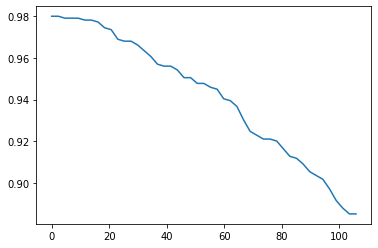

In [70]:
plot.plot(xx, scores)
plot.show()

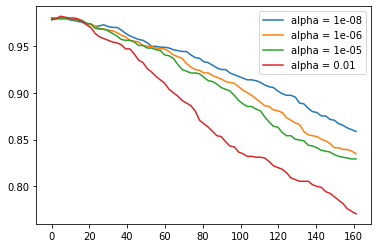

In [75]:
for alpha in [1e-08, 1e-06, 1e-05, 1e-02]:
    xx = []
    scores = []

    for lLegit in tens(0.0, 70.0):
        score, _ = evaluate(alpha, lLegit)

        xx.append(math.log(lLegit))
        scores.append(score / 10)

    plot.plot(xx, scores, label=('alpha = ' + str(alpha)))
plot.legend()
plot.show()